# Modify Battery Storage Parameters Example
---
In this example, we will show how to modify the battery storage parameters in the hybrid plant simulation. The major change is from using the default dispatch which is a profit maximization objective function to a load following objective function. The load follow objective will minimize system operating costs while load following.

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [1]:
from hopp.simulation.hybrid_simulation import HybridSimulation
from hopp.simulation.technologies.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

/Users/kbrunik/github/forked/HOPP/examples/workshop/log/hybrid_systems_2023-10-04T10.42.25.217134.log


### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.

**NOTE**: For a load following objective function the `desired_schedule` must be set.

In [2]:
import numpy as np
from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site

DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

baseload_limit_kw = float(30 * 1000)
baseload_percent = 95.0
DEFAULT_LOAD = baseload_limit_kw*np.ones((8760))/1000

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=DEFAULT_LOAD,
        solar=True,
        wind=True,
        wave=False
    )

### Define System Capacities
Define the capacities of the solar, wind, and battery components of the hybrid system in megawatts (MW).

In [3]:
solar_size_mw = 50
wind_size_mw = 50
battery_capacity_mw = 20
interconnection_size_mw = 100

### Configure Technology Parameters
Configure the characteristics of each technology in the system, including PV (solar), wind, battery, and grid interconnection.

In [5]:
technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000,
    },
    'wind': {
        'num_turbines': 10,
        'turbine_rating_kw': int(wind_size_mw * 1000 / 10)
    },
    'battery': {
        'system_capacity_kwh': battery_capacity_mw * 1000,
        'system_capacity_kw': battery_capacity_mw * 4 * 1000,
        'minimum_SOC': 20.0,
        'maximum_SOC': 100.0,
        'initial_SOC': 90.0
    },
    'grid': {
        'interconnect_kw': interconnection_size_mw * 1000
    }
}

### Specify the Battery Dispatch
Create a dictionary that will be used to instantiate the `HybridSimulation` class and configure the desired battery dispatch model.

In [6]:
dispatch_options = {'battery_dispatch': 'simple',
                        'solver': 'cbc',
                        'n_look_ahead_periods': 48, #hrs
                        'grid_charging': True,
                        'pv_charging_only': False,
                        'include_lifecycle_count': False}

### Create the Hybrid Simulation Model
Instantiate the `HybridSimulation` class by providing the technology configuration and site information.

In [7]:
hybrid_plant = HybridSimulation(technologies, site, dispatch_options)

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 20 years).

In [11]:
hybrid_plant.simulate(project_life=20)

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [12]:
print("Output after losses over gross output:",
      hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
revs = hybrid_plant.total_revenues

print("Annual Energies:")
print(annual_energies)

print("Net Present Values:")
print(npvs)

print("Total Revenues:")
print(revs)

Output after losses over gross output: 0.7997475965517965
Annual Energies:
{"pv": 104053614.17593749, "wind": 156936144.3525466, "battery": -889892.7145233898, "hybrid": 194899990.98027584}
Net Present Values:
{"pv": -34633452.62880054, "wind": -57358955.19811408, "battery": -33564722.98258493, "hybrid": -130627288.56236602}
Total Revenues:
{"pv": [0.0, 100822.81119202862, 101831.0393039489, 102849.3496969884, 103877.8431939583, 104916.62162589785, 105965.78784215686, 107025.44572057843, 108095.7001777842, 109176.65717956203, 110268.42375135767, 111371.10798887124, 112484.81906875994, 113609.66725944755, 114745.76393204203, 115893.22157136246, 117052.15378707607, 118222.67532494686, 119404.90207819629, 120598.95109897826, 121804.94060996805], "wind": [0.0, 154112.71406684216, 155653.8412075106, 157210.37961958573, 158782.48341578158, 160370.30824993938, 161974.01133243882, 163593.7514457632, 165229.6889602208, 166881.985849823, 168550.80570832125, 170236.31376540445, 171938.67690305848

### Visualize Simulation Results (Optional)
Optionally, you can visualize the simulation results using plots. Several functions are provided for plotting battery output, generation profiles, and dispatch errors.

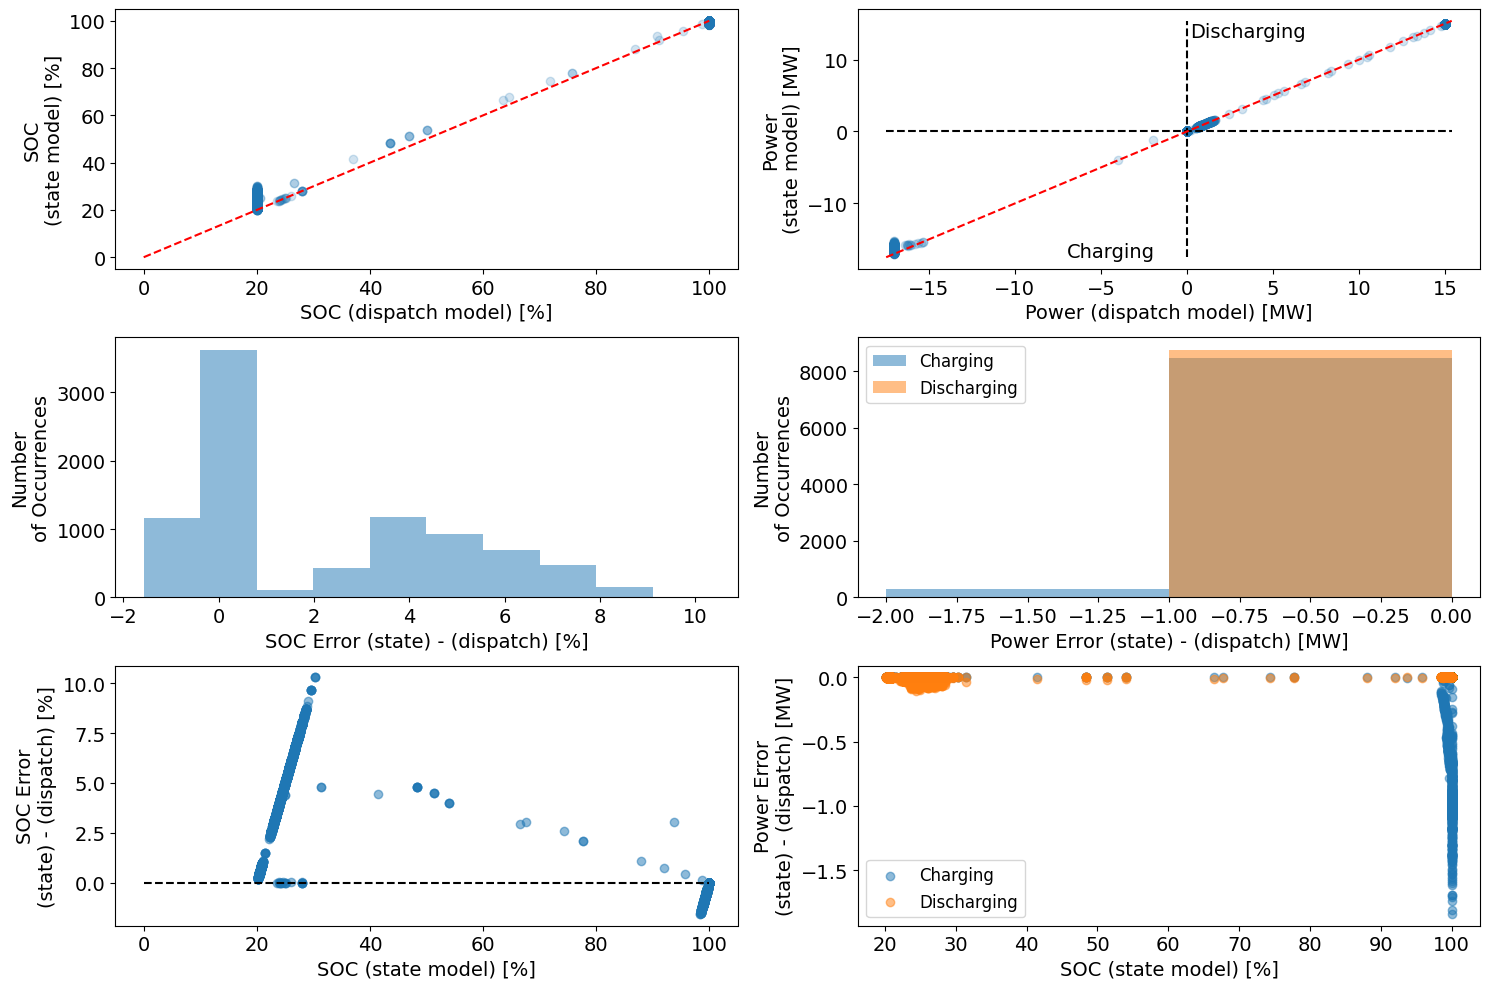

In [13]:
plot_battery_dispatch_error(hybrid_plant)

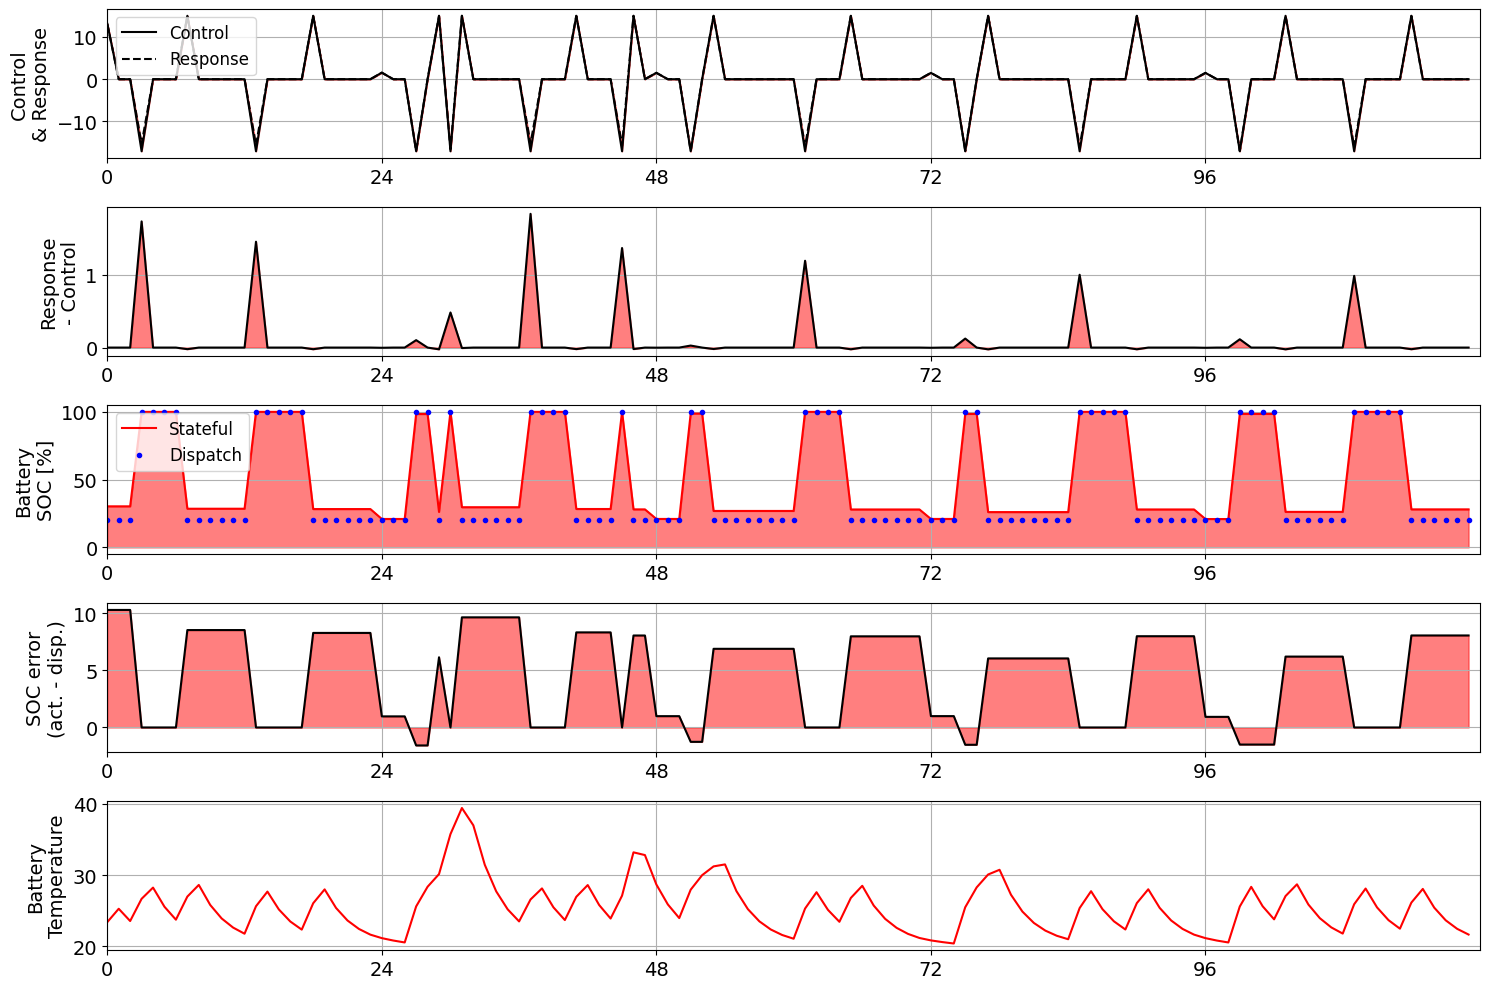

In [14]:
plot_battery_output(hybrid_plant)

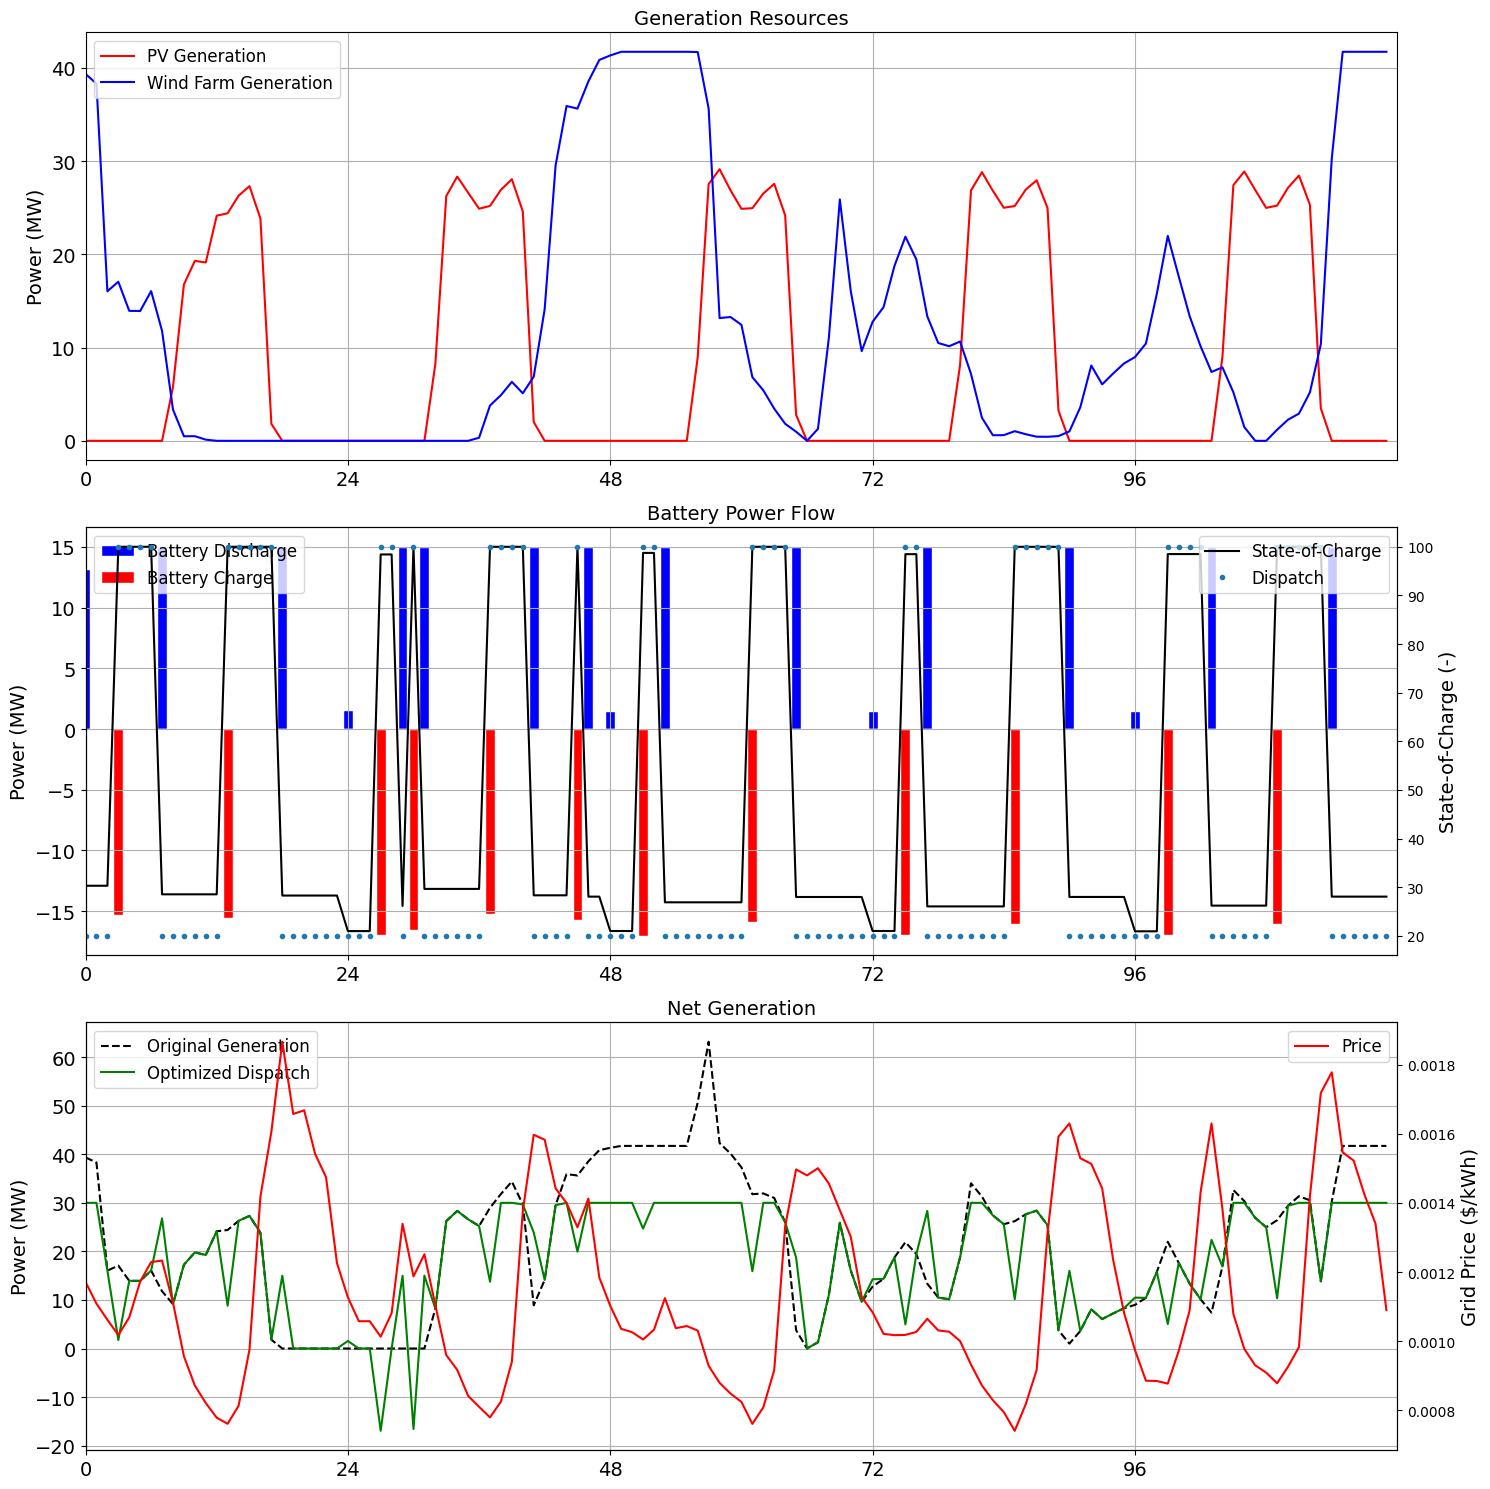

In [15]:
plot_generation_profile(hybrid_plant)